In [38]:
import jax.numpy as np
from jax import grad, value_and_grad, jit, ops

import matplotlib.pyplot as plt
%matplotlib inline 

import SSN_classes
import SSN_power_spec
import gamma_SSN_losses as losses
import make_plot
import jax.random as random
import MakeSSNconnectivity as make_conn

from importlib import reload
reload(SSN_classes)
reload(SSN_power_spec)
reload(losses)
reload(make_plot)
reload(make_conn)

<module 'MakeSSNconnectivity' from '/Users/cholt/Google Drive/Python/torch_SSN/jax_caleb/MakeSSNconnectivity.py'>

In [39]:
#the constant (non-optimized) parameters:

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([3, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
# NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

contrasts = np.array([0, 25, 50, 100])

gridsizedeg = 4
gridperdeg = 5
hyper_col = 8
Lx = 4
Ly = 4
r_cent = np.array([0.3, 0.6, 0.9, 1.2, 1.5])
contrasts = np.array([0, 25, 50, 100])

X,Y, deltaD = make_conn.make_neur_distances(gridsizedeg, gridperdeg, hyper_col, Lx, Ly, PERIODIC = True)
OMap, _= make_conn.make_orimap(hyper_col, X, Y)
Inp, stimCon = make_conn.makeInputs(OMap, r_cent, contrasts, X, Y)

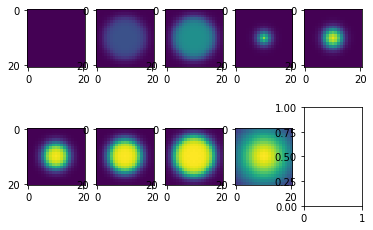

In [40]:
#plot Inp for all stim conditions
Contrasts = stimCon[ 0, :]

fig, ax = plt.subplots(2, 5)

for ii in np.arange(len(Contrasts)):
    plot_array = np.reshape(Inp[:, ii], (21,21))
    
    if ii < 5:
        plot_indy = ii
        plot_indx = 0
    else:
        plot_indy = ii - 5
        plot_indx = 1
    ax[plot_indx, plot_indy].imshow(plot_array, vmin=vvmin, vmax=vvmax)

In [42]:
params = [1.95, 1.25, 2.45, 1.5, 1.25] #Jee, Jei, Jie, Jii, i2e --- Modelo that WORKED! w/ locality = 1
Ne = 21 * 21
Ni = Ne

tau_vec = np.hstack((tauE*np.ones(Ne), tauI*np.ones(Ni)))
print(tau_vec.shape)
N = Ne + Ni #number of neurons in the grid.

(882,)


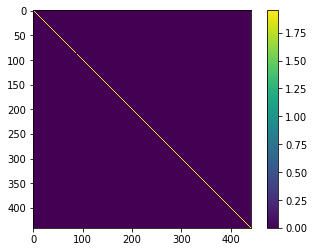

In [43]:
#unpack parameters
Jee = params[0]
Jei = params[1]
Jie = params[2]
Jii = params[3]

Plocal = 1
sigR = 0.7

if len(params) < 6:
    i2e = params[4]
    gE = 1
    gI = 1
    NMDAratio = 0.4
else:
    i2e = 1
    gE = params[4]
    gI = params[5]
    NMDAratio = params[6]
    
# cons = len(contrasts)

W = make_conn.make_full_W(Plocal, Jee, Jei, Jie, Jii, sigR)

J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) # * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
# ssn = SSN_classes.SSN_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())

# r_init = np.zeros([ssn.N, len(contrasts)])
# inp_vec = np.array([[gE], [gI*i2e]]) * contrasts

# r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)

# spect, fs, f0, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)

plt.imshow(W[:Ne, :Ne])
plt.colorbar()

In [44]:
ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, Jee, Jei, Jie, Jii)

In [68]:
ssn_Ampa = SSN_classes._SSN_AMPAGABA(tau_s, NMDAratio, n, k, Ne, Ni, tau_vec, W)

r_init = np.zeros([ssn_Ampa.N, len(Contrasts)])
# inp_vec = np.array([[gE], [gI*i2e]]) * contrasts
inp_vec = np.vstack((gE*Inp, gI*Inp))

r_fp, CONVG = ssn_Ampa.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)

[[  0.   25.   50.  100.  100.  100.  100.  100.  100. ]
 [  1.5   1.5   1.5   0.3   0.6   0.9   1.2   1.5   1.5]]
[3 4 5 6 7 8]
[0 1 2 8]


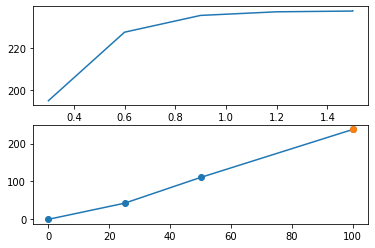

In [77]:
gen_inds = np.arange(len(Contrasts))
rad_inds = np.arange(len(contrasts)-1, len(r_cent)+len(contrasts))#np.where(stimCon[0, :] == np.max(Contrasts), gen_inds, 0)
con_inds = np.hstack((np.arange(0, len(contrasts)-1), len(r_cent) + len(contrasts)-1))#np.where(stimCon[1, :] == np.max(stimCon[1,:]), gen_inds, 0)
gabor_inds = -1

figure, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(stimCon[1, rad_inds], r_fp[220, rad_inds])
ax2.plot(stimCon[0, con_inds], r_fp[220, con_inds], '-o')
ax2.plot(stimCon[0, gabor_inds], r_fp[220, gabor_inds], 'o')
print(stimCon)
print(rad_inds)
print(con_inds)

In [78]:
r_fp.shape

(882, 9)

In [79]:
con_inds = np.hstack((con_inds, gabor_inds))
cons = len(con_inds)
ssn_Ampa.topos_vec = np.ravel(OMap)

spect, fs, f0, _ = SSN_power_spec.linear_PS_sameTime(ssn_Ampa, r_fp[220, con_inds], SSN_power_spec.NoisePars(), freq_range, fnums, cons)

ValueError: Incompatible shapes for broadcasting: ((2646, 882), (1, 5))

In [51]:
Contrasts

DeviceArray([  0.,  25.,  50., 100., 100., 100., 100., 100., 100.],
            dtype=float32)

In [27]:
import scipy.io as sio

In [38]:
JW = {'W':W}
sio.savemat('test_JW-small_sigOri.mat', JW)

In [5]:
hyper_col = 8 #this defines the hyper column. In the MATLAB code it's called lambdaC. 

gridperdeg = 5
gridsizedeg = 4

gridsize = (1 + round(gridperdeg * gridsizedeg))

# length of the x/y directions in degress
Lx = 4 # in degrees\
Ly = 4
dx = Lx/(gridsize - 1)
dy = Ly/(gridsize - 1)

[X,Y] = np.meshgrid(np.arange(0, Lx+dx, dx),np.arange(0, Ly+dy, dy))


In [6]:
kc = 2*np.pi/(hyper_col)

z = np.zeros_like(X)
nn = 30 #number of plane waves in ori map
key = random.PRNGKey(0)
subkey = key

for j in range(nn):
    kj = kc * np.array([np.cos(j * np.pi/nn), np.sin(j * np.pi/nn)])
    
    #this won't work, gotta remember how to do random numbers in jax. 
    sj = 2 * random.randint(subkey, shape=(), minval=1, maxval=3)-3 #random number that's either + or -1. 
    #randint inputs: PRNGkey, size tuple, minval (incl), maxval(excl)
    
    phij = random.uniform(subkey)*2*np.pi
    
    tmp = (X*kj[0] + Y*kj[1]) * sj + phij
    
    z = z + np.exp(1j * tmp)

#     phij = rand()*2*pi;

#     tmp = (X*kj(1)+Y*kj(2))*sj + phij;

#     z = z + exp(1i * tmp);
    
    key, subkey = random.split(key)

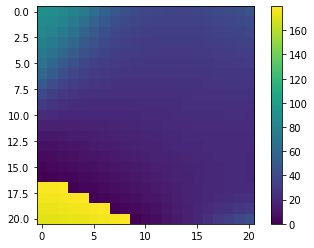

In [7]:
OMap = np.angle(z)
OMap = (OMap - np.min(OMap)) * 180/(2*np.pi)

Len = OMap.shape
Lm = Len[0]
Nthetas = len(OMap.ravel())



plt.imshow(OMap)
plt.colorbar()

In [8]:
PERIODIC = True

[indX, indY] = np.meshgrid(np.arange(21), np.arange(21))

# XDist = np.abs(np.ravel(X, 'F')[:,None] - np.ravel(X, 'F'))
XDist = np.abs(np.ravel(indX, 'F') - np.ravel(indX, 'F')[:,None])
# XDist = np.abs(XdMat - XdMat.T)

# YDist = np.abs(np.ravel(Y, 'F')[:,None] - np.ravel(Y, 'F'))
YDist = np.abs(np.ravel(indY, 'F') - np.ravel(indY,'F')[:,None])
# YDist = np.abs(YdMat - YdMat.T)

if PERIODIC:
    XDist = np.where( XDist > Len[0]/2, Len[0] - XDist, XDist) 
    YDist = np.where( YDist > Len[1]/2, Len[1] - YDist, YDist) 
#     XDist = np.where( XDist > Lx/2, Lx - XDist, XDist) 
#     YDist = np.where( YDist > Ly/2, Ly - YDist, YDist) 

OriPref = np.ravel(OMap)
OriDist = np.abs(OriPref - OriPref[:,None])
OriDist = np.where( OriDist > 90, 180- OriDist, OriDist)
# OriDist = np.abs(OridMat - OridMat.T)

deltaD = np.sqrt(XDist**2 + YDist**2)
deltaD = deltaD * Lx/(gridsize - 1)

In [9]:
JNoise_Normal = False
JNoise = 0

sigRat = 0.7

sigEE = 0.35 * np.sqrt(sigRat)
sigEI = 0.35 / np.sqrt(sigRat)
sigIE = 0.02 #small to enforce local I connections
sigII = 0.02 

sigOri = 45 #sigma for ori map. 

MinSyn = 1e-4

Wee_d = np.exp(-np.abs(deltaD)/sigEE)# - OriDist**2 / (2*sigOri**2))
Wee = np.exp(-np.abs(deltaD)/sigEE - OriDist**2 / (2*sigOri**2))
Wie = np.exp(-np.abs(deltaD)/sigIE - OriDist**2 / (2*sigOri**2))
Wei = np.exp(-deltaD**2/(2*sigEI**2) - OriDist**2 / (2*sigOri**2))
Wii = np.exp(-deltaD**2/(2*sigII**2) - OriDist**2 / (2*sigOri**2))

if JNoise_Normal:
    rand_dist = lambda x: random.normal(key, x.shape)
else:
    rand_dist = lambda x: 2*random.uniform(key, x.shape) - 1

Wee = (1 + (JNoise*rand_dist(Wee)))*Wee
Wei = (1 + (JNoise*rand_dist(Wei)))*Wei
Wie = (1 + (JNoise*rand_dist(Wie)))*Wie
Wii = (1 + (JNoise*rand_dist(Wii)))*Wii

Wee = np.where(Wee < MinSyn, 0, Wee)
Wie = np.where(Wie < MinSyn, 0, Wie)
Wei = np.where(Wei < MinSyn, 0, Wei)
Wii = np.where(Wii < MinSyn, 0, Wii)

In [10]:
tWee = np.sum(Wee_d, axis=1)
tWei = np.sum(Wei, axis=1)
tWie = np.sum(Wie, axis=1)
tWii = np.sum(Wii, axis=1)

if True: #default to true
    Wee_d = Wee_d / tWee
else:
    Wee = Wee/ mean(tWee)
    

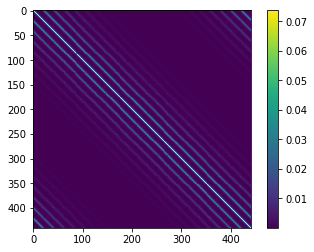

In [11]:
# plt.imshow(np.reshape(Wee_d[0, :], (21, 21), 'F'))
plt.imshow(Wee_d)
plt.colorbar()

# plt.imshow(XdMat.T)
# plt.colorbar()
# np.max(XdMat)

# plt.plot(indY)

In [27]:
def make_W_cat(dist, ori_dist, sigma, sigma_ori, from_neuron, MinSyn=1e-4, JNoise=0, JNoise_normal=False, CellWiseNormalized=True):
    
    if from_neuron == 'E':
        W = np.exp(-np.abs(dist)/sigma - ori_dist**2/(2*sigma_ori**2))
    elif from_neuron == 'I':
        W = np.exp(-dist**2/(2*sigma**2) - ori_dist**2/(2*sigma_ori**2))
    
    if JNoise_Normal:
        rand_dist = lambda x: random.normal(key, x.shape)
    else:
        rand_dist = lambda x: 2*random.uniform(key, x.shape) - 1
    
    W = (1 + (JNoise*rand_dist(W)))*W
    W = np.where(W < MinSyn, 0, W)
    tW = np.sum(W, axis=1)
    
    if CellWiseNormalized:
        W = W / tW
    else:
        W = W / np.mean(tW)
    
    return W        

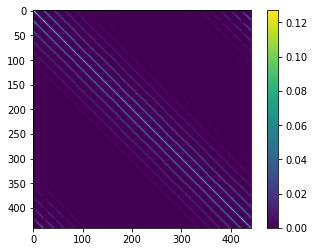

In [31]:
Wee = make_W_cat(deltaD, OriDist, sigEE, sigOri, 'E')

plt.imshow(Wee)
plt.colorbar()

In [71]:
np.max(np.sum(Wee_d, axis=1))

DeviceArray(13.576561, dtype=float32)

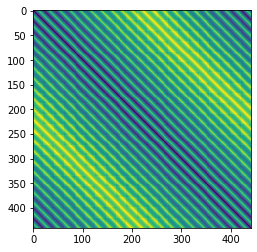

In [12]:
plt.imshow(deltaD)
# print(deltaD.shape)

dist = {"deltaD":deltaD, "Wee_d":Wee}

In [104]:
import scipy.io as sio
# sio.savemat('dist_topo.mat', dist)

## Make Input structure

In [13]:
import numpy as onp

In [86]:
Mid1 = int(round(Len[0]/2))
Mid2 = int(round(Len[1]/2))
# Python does linear indexing weird, just going to use the found midpts
# trgt = onp.ravel_multi_index((Mid1, Mid2), (Len[0], Len[1]))

AngWidth = 32
Orientation = OMap[Mid1, Mid2]

dOri = np.abs(OMap - Orientation)
dOri = np.where(dOri > 90, 180-dOri, dOri)
In0 = np.exp(-dOri**2/(2*AngWidth**2))

r_cent =  np.array([0.3, 0.6, 0.9, 1.2, 1.5]) #DEGREES
r_cent = np.array([1.5, 1.2, 0.9, 0.6, 0.3])
contrasts = np.array([0, 25, 50, 100])

rads = np.hstack((np.max(r_cent)*np.ones(len(contrasts)), r_cent))
Contrasts = np.hstack((contrasts, np.ones(len(r_cent)+1)*np.max(contrasts))) # need to add one for Gabor condition

# r_cent = np.array([1.5])
StimLength = 2*r_cent # stimulus diameter in DEGREES
RFdecay = dx

# Rmax = r_cent
GaborSigma = np.max(r_cent)

x0 = X[Mid1, Mid2]
y0 = Y[Mid1, Mid2]

x_space = X - x0
y_space = Y - y0

r_space = np.ravel(np.sqrt(x_space**2 + y_space**2))
InSr = (1 - (1/(1 + np.exp(-(r_space - rads[:, None])/RFdecay))))
InGabor = np.exp(- r_space**2/2/GaborSigma**2);
StimConds = Contrasts[:,None] * np.vstack((InSr, InGabor))
InSpace = np.hstack( (gE * StimConds, gI*StimConds)).T
# new_in = np.reshape(InSpace, (21*(len(r_cent)+1), 21), 'C')

In [53]:
if len(r_cent) == 1:
    InSr = np.reshape(InSr, (gridsize,gridsize))
else:
    InSpace = np.vstack((InSr, InGabor))
    InSpace.shape

    new_in = np.reshape(InSpace, (21, 21*6))

In [18]:
Xf, Yf, deltaDf = make_conn.make_neur_distances(gridsizedeg, gridperdeg,hyper_col, Lx, Ly)

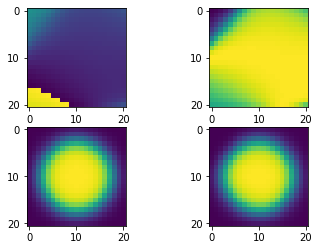

In [54]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2)

ax1.imshow(OMap)
ax2.imshow(In0)
ax3.imshow(InSr)
ax4.imshow(InSr * In0)

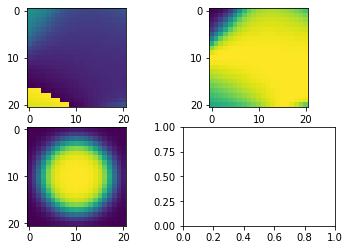

In [65]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2)

ax1.imshow(OMap)
ax2.imshow(In0)
ax3.imshow(new_in[(4*gridsize):(5*gridsize), :])
# ax4.imshow(InSr * In0)

In [106]:
inp = {'InSr':InSr, 'InO':In0}
sio.savemat('test_InSr.mat', inp)

In [69]:
contrasts = np.array([0, 25, 50, 100])

rads = np.hstack((np.max(r_cent)*np.ones(len(contrasts)), r_cent))
Contrasts = np.hstack((contrasts, np.ones(len(r_cent))*np.max(contrasts)))

In [81]:
InSpace.shape

(10, 882)

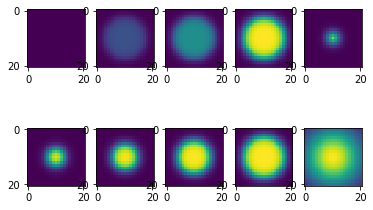

In [9]:
# inspace = InSpace
inspace = Inp.T
vvmin = np.min(inspace)
vvmax = np.max(inspace)

Contrasts = stimCon[ 0, :]

fig, ax = plt.subplots(2, 5)

for ii in np.arange(len(Contrasts)):
    plot_array = np.reshape(inspace[:441,ii], (21,21))
    
    if ii < 5:
        plot_indy = ii
        plot_indx = 0
    else:
        plot_indy = ii - 5
        plot_indx = 1
    ax[plot_indx, plot_indy].imshow(plot_array, vmin=vvmin, vmax=vvmax)

DeviceArray([0. , 1.5], dtype=float32)

In [96]:
import MakeSSNconnectivity as make_conn
reload(make_conn)

<module 'MakeSSNconnectivity' from '/Users/cholt/Google Drive/Python/torch_SSN/jax_caleb/MakeSSNconnectivity.py'>

In [97]:
gridsizedeg= 4
gridperdeg = 5
hyper_col = 8
Lx = 4
Ly = 4


X,Y, _ = make_conn.make_neur_distances(gridsizedeg, gridperdeg, hyper_col, Lx, Ly)
OMap, _= make_conn.make_orimap(hyper_col, X, Y)
Inp, stimCon = make_conn.makeInputs(OMap, r_cent, contrasts, X, Y)

NameError: name 'gE' is not defined